# LaLonde Dataset

Economists have long-hypothesized that training programs could improve the labor market prospects of participants.
In an attempt to test (or demonstrate) this, the National Supported Work (NSW) Demonstration was initiated using combined private and federal funding. This program was implemented between 1975 and 1979 in 15 locations across the US.
The program provided 6-18 month training for individuals who had faced economic and social problems (such as women receiving Aid to Families with Dependent Children, former drug addicts, ex-convicts, and former juvenile delinquents, etc.).

Participants were randomly assigned into experimental group (Support Work Programs) and control groups.
However, due to the long duration of the study, participants joining the program at the beginning had different characteristics than people joining later.  
Therefore, this covariate shift should be adjusted for in order to estimate the true causal effect of the job-program on future employment.

Furthermore, we add some observational data that was obtained from the Population Survey of Income Dynamics and the Current Population Survey. These did not receive any training and are considered controls.

This dataset had become a common benchmark for causal analysis over the years.
Original analysis of the study was done by [Robert LaLonde](https://en.wikipedia.org/wiki/Robert_LaLonde) and published in his 1986 [Evaluating the Econometric Evaluations of Training Programs with Experimental Data](http://people.hbs.edu/nashraf/LaLonde_1986.pdf) paper.  
The analysis here is based on results from a later, propensity-based, analysis made by Dehejia and Wahba in their 1999 [Causal Effects in Non-Experimental Studies: Reevaluating the Evaluation of Training Programs](https://users.nber.org/~rdehejia/papers/dehejia_wahba_jasa.pdf).

## The Data
First, let's download the dataset from [Rajeev Dehejia's webpage](https://users.nber.org/~rdehejia/nswdata2.html).

In [1]:
import pandas as pd

columns = ["training",   # Treatment assignment indicator
           "age",        # Age of participant
           "education",  # Years of education
           "black",      # Indicate whether individual is black
           "hispanic",   # Indicate whether individual is hispanic
           "married",    # Indicate whether individual is married
           "no_degree",  # Indicate if individual has no high-school diploma
           "re74",       # Real earnings in 1974, prior to study participation
           "re75",       # Real earnings in 1975, prior to study participation
           "re78"]       # Real earnings in 1978, after study end

#treated = pd.read_csv("http://www.nber.org/~rdehejia/data/nswre74_treated.txt", 
#                      delim_whitespace=True, header=None, names=columns)
#control = pd.read_csv("http://www.nber.org/~rdehejia/data/nswre74_control.txt",
#                      delim_whitespace=True, header=None, names=columns)
file_names = ["http://www.nber.org/~rdehejia/data/nswre74_treated.txt",
              "http://www.nber.org/~rdehejia/data/nswre74_control.txt",
              "http://www.nber.org/~rdehejia/data/psid_controls.txt",
              "http://www.nber.org/~rdehejia/data/psid2_controls.txt",
              "http://www.nber.org/~rdehejia/data/psid3_controls.txt",
              "http://www.nber.org/~rdehejia/data/cps_controls.txt",
              "http://www.nber.org/~rdehejia/data/cps2_controls.txt",
              "http://www.nber.org/~rdehejia/data/cps3_controls.txt"]
files = [pd.read_csv(file_name, delim_whitespace=True, header=None, names=columns) for file_name in file_names]
lalonde = pd.concat(files, ignore_index=True)
lalonde = lalonde.sample(frac=1.0, random_state=42)  # Shuffle

print(lalonde.shape)
lalonde.head()

(22106, 10)


,training,age,education,black,hispanic,married,no_degree,re74,re75,re78
16827,0.0,26.0,13.0,0.0,0.0,0.0,0.0,58.778,50.12903,31.03226
5412,0.0,27.0,12.0,0.0,0.0,1.0,0.0,16297.180,13429.21000,19562.14000
15399,0.0,26.0,12.0,0.0,0.0,0.0,0.0,5217.527,3174.24200,25564.67000
13077,0.0,38.0,16.0,0.0,0.0,1.0,0.0,23713.010,9178.98400,18814.41000
2189,0.0,55.0,8.0,0.0,0.0,1.0,1.0,0.000,0.00000,0.00000


In [2]:
print(f'The dataset contains {lalonde.shape[0]} people, out of which {lalonde["training"].sum():.0f} received training')

The dataset contains 22106 people, out of which 185 received training


### Design matrix
#### Earning indications
Following the analysis performed by Gelman et al. on their [arm](https://cran.r-project.org/web/packages/arm/index.html) R library, we will create two indicator variables indicating no earnings in 1974 and 1975.

In [3]:
lalonde = lalonde.join((lalonde[["re74", "re75"]] == 0).astype(int), rsuffix=("=0"))
lalonde.head()

,training,age,education,black,hispanic,married,no_degree,re74,re75,re78,re74=0,re75=0
16827,0.0,26.0,13.0,0.0,0.0,0.0,0.0,58.778,50.12903,31.03226,0,0
5412,0.0,27.0,12.0,0.0,0.0,1.0,0.0,16297.180,13429.21000,19562.14000,0,0
15399,0.0,26.0,12.0,0.0,0.0,0.0,0.0,5217.527,3174.24200,25564.67000,0,0
13077,0.0,38.0,16.0,0.0,0.0,1.0,0.0,23713.010,9178.98400,18814.41000,0,0
2189,0.0,55.0,8.0,0.0,0.0,1.0,1.0,0.000,0.00000,0.00000,1,1


#### Factorizing education
Since years of schooling are not to be taken by their numerical values, we will factorize it into indicator variables.

In [4]:
lalonde = pd.get_dummies(lalonde, columns=["education"], drop_first=True)
print(lalonde.shape)
lalonde.head()

(22106, 29)


,training,age,black,hispanic,married,no_degree,re74,re75,re78,re74=0,...,education_9.0,education_10.0,education_11.0,education_12.0,education_13.0,education_14.0,education_15.0,education_16.0,education_17.0,education_18.0
16827,0.0,26.0,0.0,0.0,0.0,0.0,58.778,50.12903,31.03226,0,...,0,0,0,0,1,0,0,0,0,0
5412,0.0,27.0,0.0,0.0,1.0,0.0,16297.180,13429.21000,19562.14000,0,...,0,0,0,1,0,0,0,0,0,0
15399,0.0,26.0,0.0,0.0,0.0,0.0,5217.527,3174.24200,25564.67000,0,...,0,0,0,1,0,0,0,0,0,0
13077,0.0,38.0,0.0,0.0,1.0,0.0,23713.010,9178.98400,18814.41000,0,...,0,0,0,0,0,0,0,1,0,0
2189,0.0,55.0,0.0,0.0,1.0,1.0,0.000,0.00000,0.00000,1,...,0,0,0,0,0,0,0,0,0,0


### Variables selection
Lastly, we extract the covariates, treatment and outcome variables

In [5]:
a = lalonde.pop("training")
y = lalonde.pop("re78")
X = lalonde
X.shape, a.shape, y.shape

((22106, 27), (22106,), (22106,))

## The Model
After defining the design matrix `X`, we can continue to define the causal model.

In the spirit of Dehejia and Wahba's propensity-based analysis, 
we will use an Inverse Treatment Probability Weighting (IPTW, or IPW) causal model.  
Briefly, this model will model the probability of participants to be assigned to job-training program and use it to emulate two equal-sized populations: one of those being assigned to the program and another of ones who don't.
In this synthetic population, we could use the actual earnings in 1978 to estimate what would have happen if everyone were to join the program or everyone were to not be part of it at all.

Before we define the causal model itself, we will need to use a machine learning model to estimate the propensity score $\Pr[A=1|X]$ - the probability of each participant to be assigned to job training.  
Following the design matrix we prepared above, and given the binary nature of our treatment, we will choose a logistic regression for this task.

In [6]:
from sklearn.linear_model import LogisticRegression

learner = LogisticRegression(penalty='none',  # No regularization, new in scikit-learn 0.21.*
                             solver='lbfgs', class_weight="balanced", # The classes are very imbalanced
                             max_iter=500)    # Increaed to achieve convergence with 'lbfgs' solver

Once we defined a learner, we can simply plug it into the causal model

In [7]:
from causallib.estimation import IPW

ipw = IPW(learner)

## Estimating Causal Effect
Once we defined the causal model (yes, that was all it took), we can move on to estimate the effect of job-training on yearly earnings.

First, we will fit our causal model.  
Second, we'll predict the potential outcomes: what would be the earnings in 1978 if everyone were to join the job-training or everyone were to not join the training program.
Third, we will use the two potential outcomes to estimate the effect: the difference of the two potential outcomes.

In [134]:
ipw.fit(X, a)
outcomes = ipw.estimate_population_outcome(X, a, y)
effect = ipw.estimate_effect(outcomes[1], outcomes[0])
print(outcomes)

0.0    9172.043487
1.0    6490.507783
dtype: float64


Checking the potential outcomes, we can see that the average earnings at the end of the study (1978) if everyone would have joined the program (`treatment==1`) is predicted at 6490\$ while the same averge if everyone did not join the program is estimated at (`treatment==0`) is 9172\$.

Indeed, we might conclude that job-training accounts for an income *loss* of 2682\$ on average!

This seems like a total failure, then. But in reality this doesn't make sense, since at most training would not help, but it can't hurt. Obviously something is not right here, so let's take a closer look at the model perfomrance.

## Evaluating the model and the data

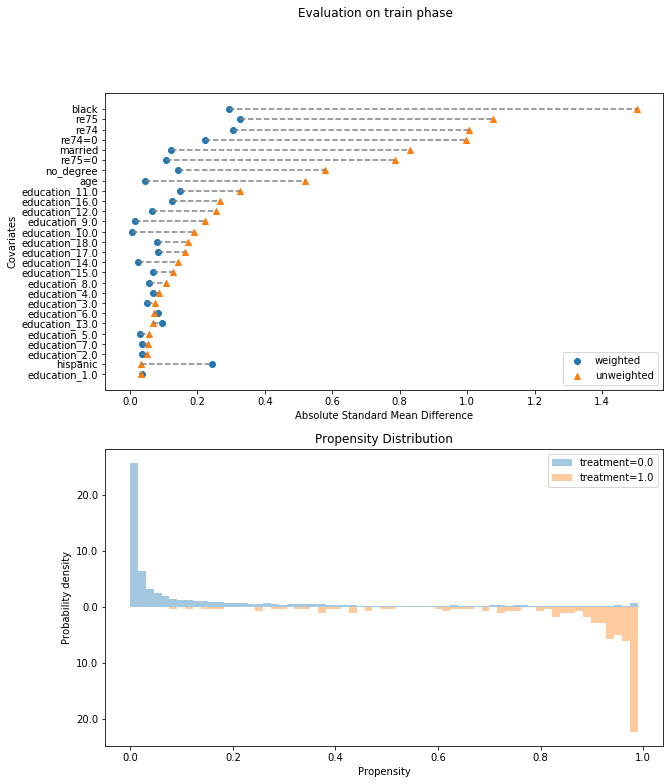

In [69]:
%matplotlib inline
from causallib.evaluation import PropensityEvaluator

evaluator = PropensityEvaluator(ipw)
plots = ["covariate_balance_love", "weight_distribution"] #, "roc_curve", "calibration"]
evaluation_results = evaluator.evaluate_simple(X, a, y, plots=plots)

fig = evaluation_results.plots["covariate_balance_love"].get_figure()
fig.set_size_inches(10, 12)  # set a more compact size than default
fig;

From the covariate balancing plot (top) We can see that many features are incredibly biased between the treated and untreated groups, specifically black, earnings at 1974, earnings at 1975, and marital status.

From the propensity distribution plot (bottom) we can see that the model was able to discern with almost certainty who was going to receive training and who wasn't. This indicates a problem in positivity, where there are populations we cannot compare because they never had the chance to receive any other treatment from what they actually got.

### Resolve positivity violation

In this case we need to investigate what is causing the lack of positivity and adjust the data accordingly.
In the originial paper by Dehejia et al. they simply removed the individuals with low propensities, where there is an obvious lack of positivity (no treated at all). 
The problem with such an approach is that we are removing parts of the data without knowing the characteristics of that data. It should be noted that by removing parts of the data our results will be limited only to the remaining data, but if we do not characterize the part we are removing we might still assume that our conclusions are applicable for the whole population, while they are not. 

Therefore, let's first try to identify who these individuals might be and correct the data in a way that we can say who is removed.

To do this we can check the model using a decision tree for classifying who we wish to remove:

In [135]:
min_val = min(ipw.compute_propensity_matrix(X[a==1])[1])
violating = pd.Series(ipw.compute_propensity_matrix(X)[1] < min_val).rename("")
min_val

0.08907563929939052

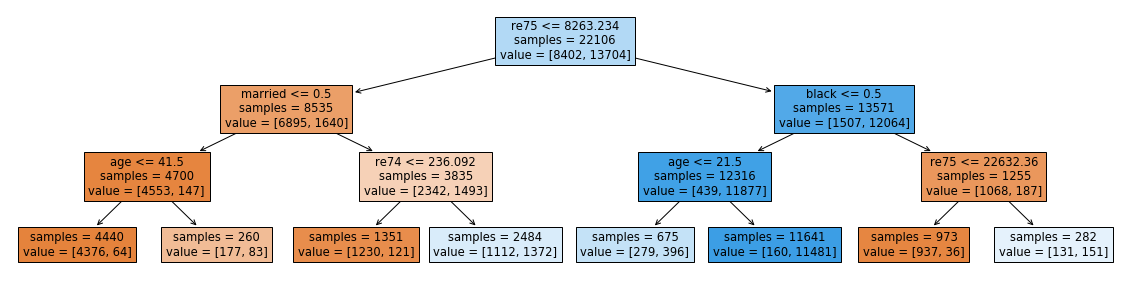

In [71]:
from sklearn import tree
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
dtc = tree.DecisionTreeClassifier(max_depth=3)
dtc.fit(X, violating)
details = tree.plot_tree(dtc, filled=True, feature_names=X.columns, impurity=False)

In the root of the tree we see that there are 13704 individuals who we correctly identified as people who will never receive training. As many of those as possible should be removed from the analysis.
One major category of such people (blue rectangles) are those who earned more than $8263 in 1975, were not black, and were older than 21. 

In [136]:
new_a = (X["re75"]>8263) & (X["black"]==0) & (X["age"] > 21)
new_a = pd.Series(new_a, name="to_remove")
pd.concat({
    "violation": pd.crosstab(new_a, violating),
    "treated": pd.crosstab(new_a, a)}, 
    axis="columns"
)

violation        treated      
              False  True    False True 
to_remove                               
False          8242   2223   10282   183
True            160  11481   11639     2

Indeed, using this categorization we will correctly remove 11641 people. Only 2 of those received training, 
and 11481 of them are part of the positivity violating population, but also 160 who are not.

By playing around a bit with the cutoffs (the decision tree we used optimized for the gini index, not for positivity identification and so we are justified to adjust it) we can obtain an even more specific removal
By repeating this analysis (not shown here) we identify a few additional populations that can also be removed.
Below is a summary of populaitons that will not be included in the analysis:

|Ethnicity|\$ in 74|\$ in 75|age|Married|
|---------|--------|--------|---|-------|
|Non Black| Any    | >10K   |>21| Any   |
|Non Black| Any    | >5.5K  |Any| Yes   |
|Non Black| Any    | >13K   |<40| Any   |
|Non Black| >0     | Any    |>39| Any   |
| Any     | >20K   | >15K   |>40| Any   |

These rules may be because of the guidelines for accepting people into the NSW program or because of inherent differences in people who apply to such programs.
In any case, using the whole population from general surveys is not a fair comparison. 
Let's reduce the cohort accordingly:


In [140]:
new_a = (X["re75"]>10000) & (X["black"]==0) & (X["age"] > 21)
new_a = new_a | ((X["re75"]>5500) & (X["black"]==0) & (X["married"]==1))
new_a = new_a | ((X["age"]<40) & (X["black"]==0) & (X["re75"]>13000))
new_a = new_a | ((X["age"]>=40) & (X["black"]==0) & (X["re74"]>0))
new_a = new_a | ((X["age"]>40) & (X["re74"]>20000) & (X["re75"]>15000))
new_a = pd.Series(new_a, name="to_remove")
pd.concat({
    "violation": pd.crosstab(new_a, violating),
    "treated": pd.crosstab(new_a, a)}, 
    axis="columns"
)

violation        treated      
              False  True    False True 
to_remove                               
False          8006    659    8481   184
True            396  13045   13440     1

Thus, we were able to remove 13045 out of the 13704 people who appear to belong to the population that violates positivity
(see the base of the tree), 
while erroneously removing only 396 who are not. 
Additionally, we only removed a single person who actually received training.
Finally, there are 659 people who are in the positivity violating population and are not removed.

We therefore defined a rule-based model that characterizes the positivity-violating population with a recall of 95.2% and a precision of 97%

While this could be improved further, we will use this model going forward.

In [138]:
X2, a2, y2 = X.loc[~new_a, :], a[~new_a], y[~new_a]

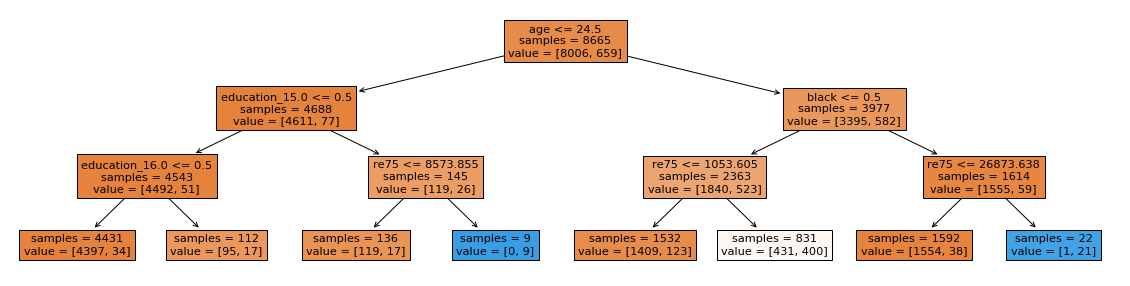

In [147]:
violating2 = pd.Series(ipw.compute_propensity_matrix(X2)[1] < min_val).rename("")
plt.figure(figsize=(20,5))
dtc = tree.DecisionTreeClassifier(max_depth=3)
dtc.fit(X2, violating2)
details = tree.plot_tree(dtc, filled=True, feature_names=X2.columns, impurity=False)

Additional rounds do not provide large specific populations to remove, and so we will stop the iterations here and re-run the analysis.

The average earnings with training are $6895.68 and without training $6368.78.
This translates to an effect of $526.90


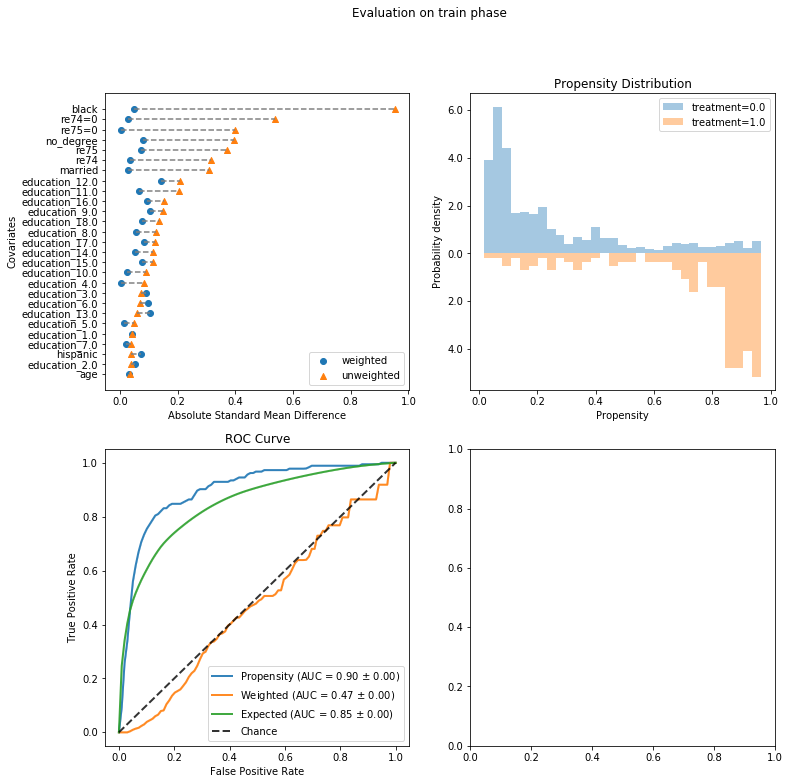

In [150]:
X2, a2, y2 = X2.loc[~violating2, :], a2[~violating2], y2[~violating2]
ipw2 = IPW(learner)
ipw2.fit(X2, a2)
outcomes2 = ipw2.estimate_population_outcome(X2, a2, y2)
effect2 = ipw2.estimate_effect(outcomes2[1], outcomes2[0])
print(f"The average earnings with training are ${outcomes2[1]:.2f}", \
      f"and without training ${outcomes2[0]:.2f}.")
print(f"This translates to an effect of ${effect2[0]:.2f}")
evaluator2 = PropensityEvaluator(ipw2)
plots = ["covariate_balance_love", "weight_distribution", "roc_curve"]
evaluation_results2 = evaluator2.evaluate_simple(X2, a2, y2, plots=plots)

fig = evaluation_results2.plots["covariate_balance_love"].get_figure()
fig.set_size_inches(12, 12)

This looks much better. Now we are able to balance all the features (top-left). 
The propensity distribution (top-right) doesn't show a large violation of positivity 
(although we know from the previous analysis that some remains).
The ROC curve (bottom-left) shows that there is still a bit of positivity violation in that the AUC is a bit high, but importantly, the weighted curve shows that the overall balancing is quite good, since it lies close to the random diagonal line, as required.

Furthermore, now we see that there is a small positive effect to training.

## Conclusion
We saw that adding a lot of data to our analysis does not neccessarily help our analysis, and in fact there is data that should not be included in the analysis.
The propensity evaluations allow identifying the parts of the data that should and should not be included.

Eventually, the estimation we obtained using the whole data set shows a very small effect of training for the earning potential of the trainees.

When comparing to the paper by Dehejia and Wahba where they identified an effect of about \$1700 
(a replication of their results using `causallib` is available [here](https://nbviewer.jupyter.org/github/IBM/causallib/blob/master/examples/Dehejia_Wahba_replication.ipynb)), 
we can only conclude that the controls that they used are not representative of the population, and include people with very low earnings. It is possible that additional characterization of the population that they removed to reach their conclusion will allow to better understand the differences.